# SVM Classification: Baselines -> Pipeline -> Tuning -> Evaluation

This notebook takes a second look at Assignment 16.2 and how else you might approach it. 

We'll also take a practical look at Support Vector Machines (SVMs) and why they’re often a good fit when the relationship between features and labels isn’t clean or linear. 

Rather than jumping straight into the model (kernels and hyperparameters), we start by looking at the dataset with a data scientist mindset - exploring the data and looking for signs of non-linear structure. This helps us to understand why we might want to use SVM in the first place.


### Libraries

In [ ]:
import numpy as np
import pandas as pd

# Data
from sklearn.datasets import load_wine

#EDA (Non-linear feature analysis)
from sklearn.feature_selection import mutual_info_classif, r_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import partial_dependence

#Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

#Visuals
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
RANDOM_STATE = 42


In [2]:
import sys
from pathlib import Path

parent = Path.cwd().parent
sys.path.insert(0, str(parent))

from helpers.data_cleaners import summary_stats

## Load Data

In [3]:
# Load data
X, y = load_wine(return_X_y=True, as_frame=True)

## EDA

### Summary Stats

In [ ]:
summary_stats(X)

,dtype,sample_val,vals,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
alcohol,float64,12.69,178,0.0,126,13.00,12.37,11.03,14.83,0.81,-0.1,-0.9
malic_acid,float64,3.70,178,0.0,133,2.34,1.73,0.74,5.80,1.12,1.0,0.3
ash,float64,2.80,178,0.0,79,2.37,2.28,1.36,3.23,0.27,-0.2,1.1
alcalinity_of_ash,float64,20.00,178,0.0,63,19.49,20.00,10.60,30.00,3.34,0.2,0.5
magnesium,float64,106.00,178,0.0,53,99.74,88.00,70.00,162.00,14.28,1.1,2.1
total_phenols,float64,2.56,178,0.0,97,2.30,2.20,0.98,3.88,0.63,0.1,-0.8
flavanoids,float64,0.63,178,0.0,132,2.03,2.65,0.34,5.08,1.00,0.0,-0.9
nonflavanoid_phenols,float64,0.37,178,0.0,39,0.36,0.26,0.13,0.66,0.12,0.5,-0.6
proanthocyanins,float64,2.14,178,0.0,101,1.59,1.35,0.41,3.58,0.57,0.5,0.6
color_intensity,float64,3.08,178,0.0,132,5.06,2.60,1.28,13.00,2.32,0.9,0.4


In [116]:
y.value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

This is a small dataset with 13 numeric features (dimensions) and 3 y values (0, 1, 2) i.e. a multi-classification dataset, containing information about 3 wine types from the same Italian region. 

### Detect Non-linear features

2 options:
1. Implicit: Run a quick ensemble of linear and non-linear multiple models, and see which ones perform better
2. Explicit: Mutual Information (MI) vs. correlation, and Partial Dependence Plots (PDP)

*MI vs. correlation tells you whether non-linearity is present; PDPs tell you what that non-linearity looks like.*

#### Mutual Information v Correlation
MI tells us how much information a feature (X) provides about the target — linear or non-linear.

By comparing MI against correlation (which captures linear relationships only), we can identify features that are likely contributing non-linearly to the model.

In [63]:
corr = pd.Series(np.abs(r_regression(X, y)),index=X.columns)

X_scaled = StandardScaler().fit_transform(X)
mi = pd.Series(mutual_info_classif(X_scaled, y, random_state=RANDOM_STATE), index=X.columns)

mi_corr_df = (pd.DataFrame({"corr": corr,"mi": mi}).sort_values("mi", ascending=False))
mi_corr_df.head()

,corr,mi
flavanoids,0.847498,0.667602
proline,0.633717,0.577391
color_intensity,0.265668,0.548274
od280/od315_of_diluted_wines,0.788230,0.516158
alcohol,0.328222,0.474312


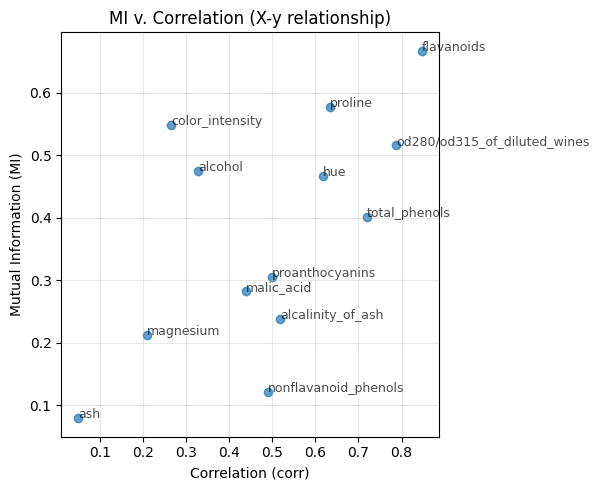

In [ ]:
plt.figure(figsize=(6, 5))

plt.scatter(mi_corr_df["corr"],mi_corr_df["mi"],alpha=0.7)

for feature in mi_corr_df.index: 
    plt.text(
        mi_corr_df.loc[feature, "corr"],
        mi_corr_df.loc[feature, "mi"],
        feature,
        fontsize=9,
        alpha=0.7
    )

plt.xlabel("Correlation (corr)")
plt.ylabel("Mutual Information (MI)")
plt.title("MI v. Correlation (X-y relationship)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The MI vs correlation analysis indicates that X features such as **color_intensity** and **alcohol** have a mild non-linear relationships with the y target i.e. they are mildy non-linear features. 

However, the lack of features with high MI and low correlation suggests that most likely linear classifiers will like perform well with this dataset too

#### Partial Dependence Plots (PDP)

Another technique is using Partial Dependence Plots - which first models, then charts the predicted Y class/feature (avg. probability) at a given X feature value.

*If the PDP isn’t a straight line, the relationship isn’t linear.*

For PDP, we'll use a Random Forest (RF) Classifier as we haven't (yet!) scaled our data

In [65]:
rf_pdp = RandomForestClassifier(n_estimators=400,random_state=RANDOM_STATE,n_jobs=-1,class_weight="balanced")
rf_pdp.fit(X, y)

,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [66]:
pdp_rows = []
grid_resolution = 50

for feature in mi_corr_df.index:
    pd_out = partial_dependence(
        rf_pdp,
        X,
        features=[feature],
        grid_resolution=grid_resolution
    )

    avg = pd_out["average"]            
    grid = pd_out["grid_values"][0]  

    avg = np.array(avg)

    n_targets = avg.shape[0]
    classes = list(rf_pdp.classes_)
    
    for class_idx, class_label in enumerate(classes[:n_targets]):
        for feat, pdp_val in zip(grid, avg[class_idx]):
            pdp_rows.append({
                "feature": feature,
                "class": class_label,
                "feature_value": feat,
                "pdp": float(pdp_val)
            })

pdp_df = pd.DataFrame(pdp_rows)

pdp_df.head()


,feature,class,feature_value,pdp
0,flavanoids,0,0.529300,0.189747
1,flavanoids,0,0.590427,0.189775
2,flavanoids,0,0.651553,0.189775
3,flavanoids,0,0.712680,0.189775
4,flavanoids,0,0.773806,0.189775


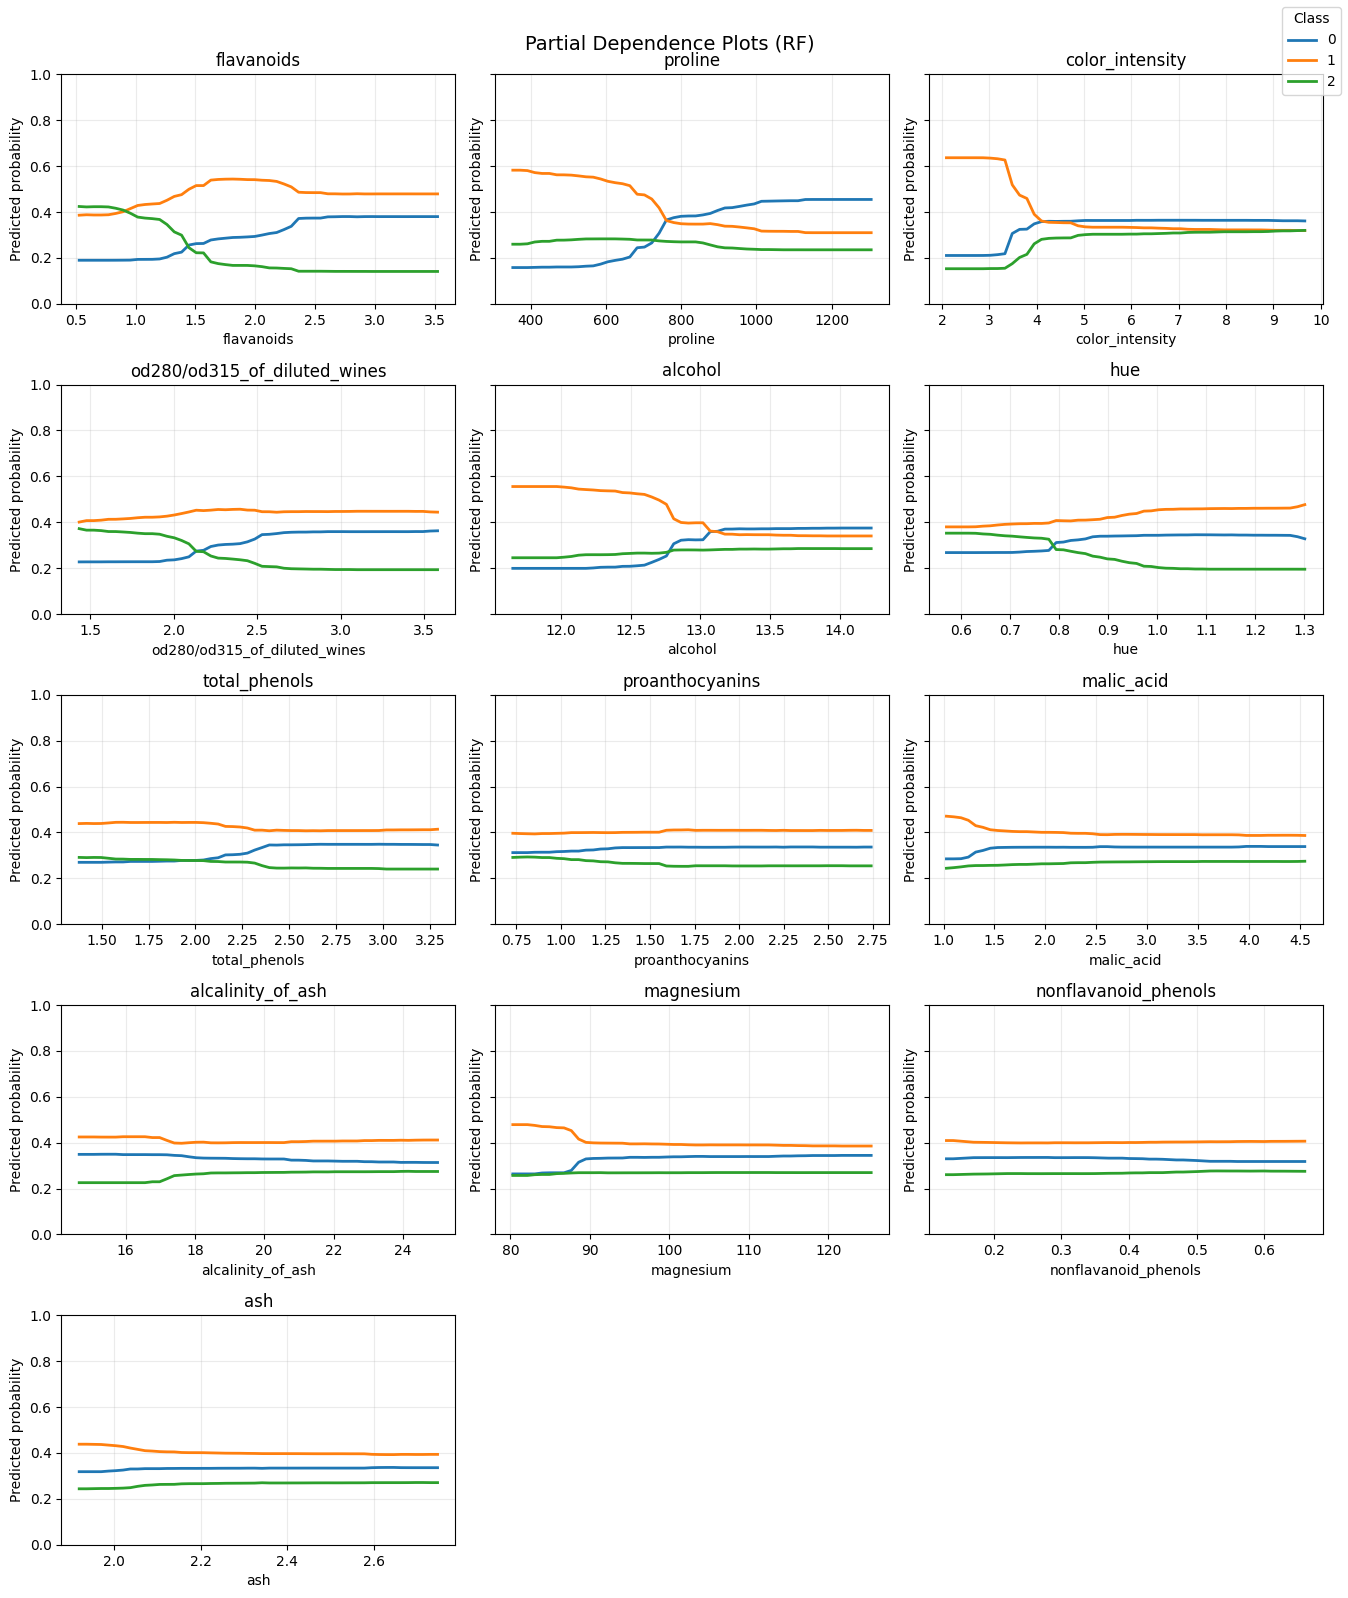

In [ ]:
n_cols = 3
n_rows = int(np.ceil(len(mi_corr_df.index) / n_cols))

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4.5 * n_cols, 3.2 * n_rows),
    sharey=True
)

axes = np.array(axes).reshape(-1)

classes = pdp_df["class"].unique()
colors = plt.cm.tab10.colors[:len(classes)]

for i, feature in enumerate(mi_corr_df.index):
    ax = axes[i]

    feature_df = pdp_df[pdp_df["feature"] == feature]

    for c, color in zip(classes, colors):
        class_df = feature_df[feature_df["class"] == c]

        ax.plot(
            class_df["feature_value"],
            class_df["pdp"],
            label=str(c),
            linewidth=2,
            color=color
        )

    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("Predicted probability")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.25)

# Drop empty charts
for ax in axes[len(mi_corr_df.index):]:
    ax.axis("off")
    
fig.suptitle("Partial Dependence Plots (RF)", fontsize=14)
fig.legend(
    [str(c) for c in classes],
    title="Class",
    loc="upper right"
)

plt.tight_layout()
plt.show()


## Model Preparation
Support Vector Machines (SVM) is a popular classification algo/model that predicts a class from a set of features, based on the similarity of those features in the training dataset (like KNN).

It's goal is **margin maximisation** i.e. creating a linear separation (as wide as possible) between the 'hyperplane' line and each class's support vectors (the datapoints closest to the margin). 

But how do you create linear separation from non-linear, low-dimension feature sets? Covers Theorem says try increasing the no. of features!

(In general, we can aim for linear separation by having the no. columns/features "m" >= no. rows/samples "n")

But I have a lot more rows "n" than "m" columns in my dataset, what can I do?

Welcome, Kernel Trick. Kernel Trick increases your features/dimensions by computing a **similarity measure between every pair of datapoints** in the dataset (including each datapoint with itself), after scaling. 

These similarity computations are **dot-product based**, with the scores stored in a **kernel (gram) matrix**.
- Linear: dot product of scaled orig. features
- Poly: dot product of polynomial feature expansions
- RBF: dot product in an infinite dimensional space
- Sigmoid: dot product passed through a non-linear activation function

The kernel matrix now effectively acts as a new feature representation:
- each row still represents a datapoint/row from our original dataset 
- each column represents the similarity between that datapoint and every other datapoint

*Tip: don't get confused! The Kernel trick is just a way to describe a data transformation technique used in SVM and other kernel-based models. All models require some form of data transformation/feature engineering for optimal results*

The SVM then optimizes the margin in this implicit feature space, using the kernel matrix directly rather than the explicit features in our original dataset.
That's it!

### Split dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=RANDOM_STATE,stratify=y)

### Establish Baselines

As discussed previously, baselines help to establish the minimum expected performance, if you did basically did nothing! 

Note: we'll take a look later at a linear model (logistic regression) as a second baseline

In [69]:
# Dummy Baseline (FYI most frequent was Class 1 at 0.398876)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

dummy_pred = dummy.predict(X_test)
print("Dummy accuracy:", accuracy_score(y_test, dummy_pred))
print("Dummy macro F1:", round(f1_score(y_test, dummy_pred, average="macro"), 2))


Dummy accuracy: 0.4
Dummy macro F1: 0.19


## Cross-validation and grid search
Cross-validation is a technique used to estimate the generalizability of a model by using different subsets of the data for training and validation. It helps assess how well a model is expected to perform on unseen data.

During k-fold cross-validation, the training data is divided into 'k' subsets, or folds. The model is then trained on 'k-1' folds (Training Data) and validated on the remaining fold (Validation Dataset).

This process is repeated 'k' times, with each fold serving as the validation dataset set once. 



Note: if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used (Stratified K-fold is also more suitable for unbalanced data)

### Scaling within the CV fold (Pipeline)

As we're splitting the training data again into folds, we want to scale the data within each fold and not the overall X_train dataset (to avoid data leakage) 


In [4]:
svm_pipe = Pipeline([("scaler", StandardScaler()),("svc", SVC()),])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


### GridSearchCV
GridSearchCV is an algorithm for hyperparameter tuning, often used in conjunction with cross-validation (hence the 'CV' in the name) where the average performance across all 'k' iterations is used to determine the best hyperparameters from the grid.

It exhaustively tries all combinations of hyperparameters provided in a predefined grid to find the best combination.

When uses in conjunction with grid search, the average performance across all 'k' iterations can also be used to determine the best hyperparameters from the grid.

### Model Parameters
#### SVM (C)
The "C" parameter is a scaling parameter used in SVM
**C**: margin/boundary strictness
- High C → prioritizes training accuracy, tighter boundary, higher overfitting risk
- Low C → wider margin, stronger regularization, better generalization (often faster, more stable)

#### Kernels
The other params used in model training are related to the kernels. 
Remember, in model training we're simply tinkering with the params in each kernel formula

e.g. the polynomial kernel is defined as $K(x, x') = (\gamma\, x^\top x' + \text{coef0})^{\text{degree}}$.

**gamma** (RBF/poly/sigmoid): locality of influence
- High γ → very local, complex boundary, overfitting risk, higher computation
- Low γ → smoother, more global boundary, better generalization, lower variance

coef0 
**degree** (poly): complexity of polynomial interactions




In [5]:
param_grid = [
    {
        "svc__kernel": ["linear"],
        "svc__C": [0.1, 1, 10, 100],
    },
    {
        "svc__kernel": ["rbf"],
        "svc__C": [0.1, 1, 10, 100],
        "svc__gamma": ["scale", "auto", 0.01, 0.1, 1.0],
    },
    {
        "svc__kernel": ["poly"],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", "auto", 0.01, 0.1],
        "svc__degree": [2, 3, 4],
        "svc__coef0": [0.0, 1.0],
    },
    {
        "svc__kernel": ["sigmoid"],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", "auto", 0.01, 0.1, 1.0],
        "svc__coef0": [0.0, 1.0],
    },
]


## Run Model

Under the hood, what will happen next is:
1. X_train consists of our feature vectors, which you can think of as dataframe rows - with each value representing a feature (column)
2. We split/fold our X_train dataset into 5 stratified folds, and then scale (StandardScaler) both the training and validation folds
3. For each fold and each hyperparameter combination, we apply a kernel function (RBF / Poly / etc., along with a unique set of kernel parameters from param_grid) to compute a similarity measure between every pair of training feature vectors.
4. These similarity computations are stored in a kernel (Gram) matrix for the training data within that fold.
5. The SVM optimization algorithm uses the kernel matrix and the corresponding value of C to solve the maximum-margin (soft-margin) optimization problem for that fold.
6. The trained model is evaluated on the validation portion of the fold, and the performance metric (macro-F1) is recorded.

Steps 2–6 are repeated across all folds, and the mean macro-F1 score is computed for that specific hyperparameter combination.
- This entire process is repeated for every hyperparameter configuration in param_grid.

The hyperparameter config with the best mean CV macro-F1 score is selected, and the pipeline is automatically refit on the full X_train dataset )(using those parameters).

The refit model is then evaluated once on the held-out X_test dataset to estimate generalization performance and confirm the final model configuration for production.

In [8]:
search = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring="f1_macro", 
    n_jobs=-1,
    cv=cv,
    refit=True,
    verbose=0,
)

search.fit(X_train, y_train)

,estimator,"Pipeline(step...svc', SVC())])"
,param_grid,"[{'svc__C': [0.1, 1, ...], 'svc__kernel': ['linear']}, {'svc__C': [0.1, 1, ...], 'svc__gamma': ['scale', 'auto', ...], 'svc__kernel': ['rbf']}, ...]"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


## Evaluation
### Confusion Matrix

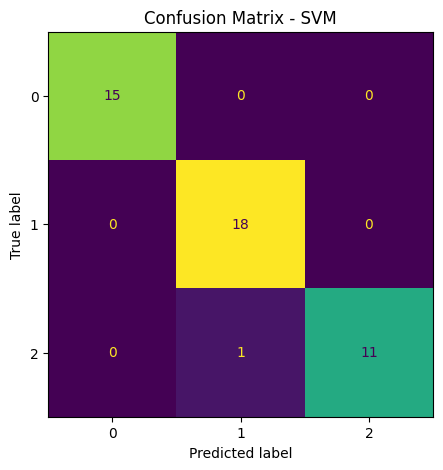

In [110]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)
ax.set_title("Confusion Matrix - SVM")
plt.show()

### F1/Accuracy v. Latency

In [12]:
res = pd.DataFrame(search.cv_results_)

df = pd.concat([res[["mean_test_score", "mean_fit_time"]],res["params"].apply(pd.Series)],axis=1
    ).rename(columns={
        "mean_test_score": "macro_f1",
        "mean_fit_time": "latency",
        "svc__C": "c_param",
        "svc__kernel": "kernel",
        "svc__gamma": "gamma_param",
        "svc__coef0": "coef0_param",
        "svc__degree": "degree_param",
    })

core_cols = ["kernel", "macro_f1", "latency"]
param_cols = [c for c in df.columns if c.endswith("_param") and c not in core_cols]

df = df[core_cols + param_cols].sort_values(by=["macro_f1", "latency"],ascending=[False, True])

df.head(10)
# c param 0.1, coef0: 1, degree_param: 3, gamma: scale, auto, 0.1


,kernel,macro_f1,latency,c_param,gamma_param,coef0_param,degree_param
41,poly,0.992381,0.001016,0.1,auto,1.0,3.0
40,poly,0.992381,0.001077,0.1,scale,1.0,3.0
43,poly,0.992381,0.001196,0.1,0.1,1.0,3.0
10,rbf,0.992381,0.001423,1.0,auto,NaN,NaN
22,rbf,0.992381,0.001776,100.0,0.1,NaN,NaN
15,rbf,0.992381,0.001803,10.0,auto,NaN,NaN
20,rbf,0.992381,0.001938,100.0,auto,NaN,NaN
19,rbf,0.992381,0.002212,100.0,scale,NaN,NaN
14,rbf,0.992381,0.002256,10.0,scale,NaN,NaN
17,rbf,0.992381,0.002344,10.0,0.1,NaN,NaN


### Linear Baseline
Better than linear? 

In [ ]:
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)),
])

param_grid_linear = [
    {
        "logreg__penalty": ["l2"],
        "logreg__C": [0.01, 0.1, 1, 10, 100],
        "logreg__solver": ["lbfgs", "newton-cg", "saga"],
    },
    {
        "logreg__penalty": ["l1"],
        "logreg__C": [0.01, 0.1, 1, 10],
        "logreg__solver": ["saga"],
    },
]

search_linear = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid_linear,
    scoring="f1_macro", 
    n_jobs=-1,
    cv=cv,
    refit=True,
    verbose=0,
)

search_linear.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logreg__C': [0.01, 0.1, ...], 'logreg__penalty': ['l2'], 'logreg__solver': ['lbfgs', 'newton-cg', ...]}, {'logreg__C': [0.01, 0.1, ...], 'logreg__penalty': ['l1'], 'logreg__solver': ['saga']}]"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [ ]:
res_linear = pd.DataFrame(search_linear.cv_results_)
res_linear

df_linear = pd.concat(
    [
        res_linear[["mean_test_score", "mean_fit_time"]],
        res_linear["params"].apply(pd.Series)
    ],
    axis=1
).rename(columns={
    "mean_test_score": "macro_f1",
    "mean_fit_time": "latency",
    "logreg__C": "c_param",
    "logreg__penalty": "penalty",
    "logreg__solver": "solver_param",
})

df_linear = df_linear.sort_values(by=["macro_f1", "latency"],ascending=[False, True])

df_linear.head()

,macro_f1,latency,c_param,penalty,solver_param
5,0.98538,0.001649,0.10,l2,saga
2,0.98538,0.001672,0.01,l2,saga
3,0.98538,0.001917,0.10,l2,lbfgs
4,0.98538,0.002255,0.10,l2,newton-cg
1,0.98538,0.002798,0.01,l2,newton-cg


In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

knn_param_grid = {
    "knn__n_neighbors": [3, 5, 7, 11, 15, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}

knn_search = GridSearchCV(
    estimator=knn_pipe,
    param_grid=knn_param_grid,
    scoring="f1_macro",
    n_jobs=-1,
    cv=cv,
    refit=True,
    verbose=0,
)
knn_search.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'knn__n_neighbors': [3, 5, ...], 'knn__p': [1, 2], 'knn__weights': ['uniform', 'distance']}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [19]:
res_knn = pd.DataFrame(knn_search.cv_results_)

df_knn = pd.concat(
    [
        res_knn[["mean_test_score", "mean_fit_time"]],
        res_knn["params"].apply(pd.Series)
    ],
    axis=1
).rename(columns={
    "mean_test_score": "macro_f1",
    "mean_fit_time": "latency",
})

df_knn = df_knn.sort_values(by=["macro_f1", "latency"],ascending=[False, True])

df_knn.head()

,macro_f1,latency,knn__n_neighbors,knn__p,knn__weights
8,0.993317,0.001409,7,1,uniform
5,0.993317,0.001678,5,1,distance
9,0.993317,0.002035,7,1,distance
4,0.986299,0.001781,5,1,uniform
1,0.985698,0.002963,3,1,distance


## Summary

In summary, Polynomial kernels slightly outperform RBF kernels in the final ranking due to equivalent cross-validated performance (0.992381) and lower inference latency (0.001110). Logistic Regression also performs well, albeit below Poly and RBF, indicative of the mild non-linearity identified during our EDA. 

These results show that SVM works well for predicting 2-3 classifications on a small/medium size dataset. Decision Trees and Logistic Regression are often helpful baselines to use/compare. KNN can work here too as seen by its higher performance (0.993317) but higher latency (0.001409)

Logistic Regression (LR) can often give similar performance, particularly when the non-linearity is mild. 

LR is probably preferred when datasets start to get larger although Linear kernel-SVM should be fine too (other kernels scale quadratically - better options are available)

As classification requirements >3 classes, you'll probably look at other models like XGBoost (out of scope)
